xG                          1.660116
key_passes                 11.824810
pass_count                644.600653
successfull_pass_count    499.035546
xA                          1.119747
won_duels                  15.616975
successful_tackles          6.380123
interception_count         15.795793
foul_committed_count       20.068190
fouls_suffered_count       19.126224
dtype: float64
Athletic Club


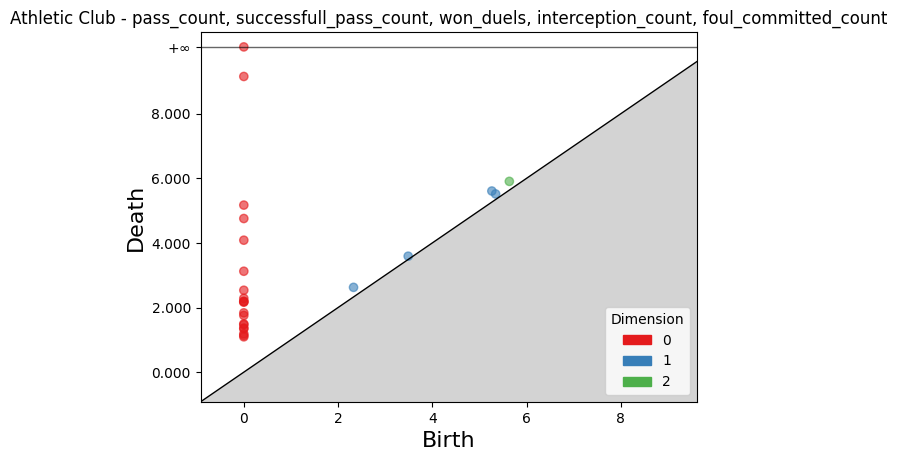

Atlético Madrid


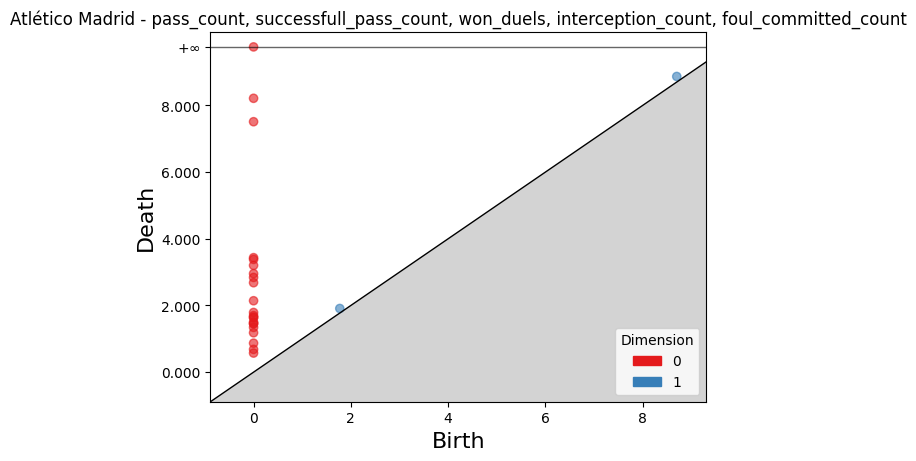

Barcelona


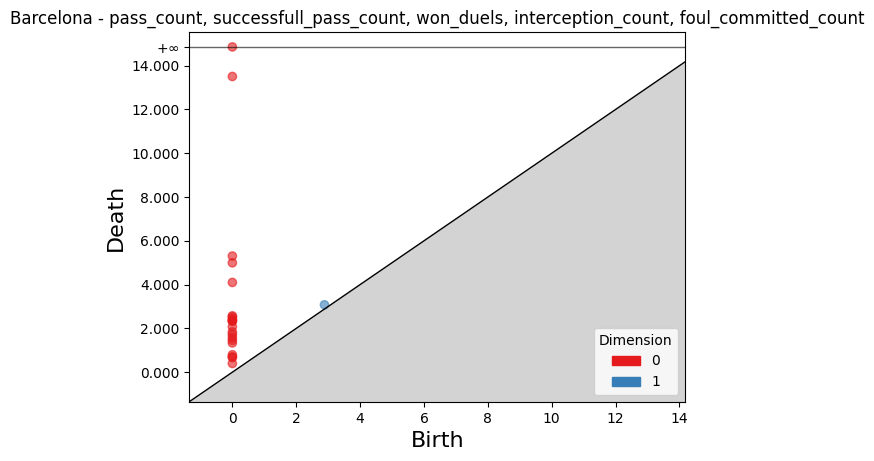

Celta Vigo


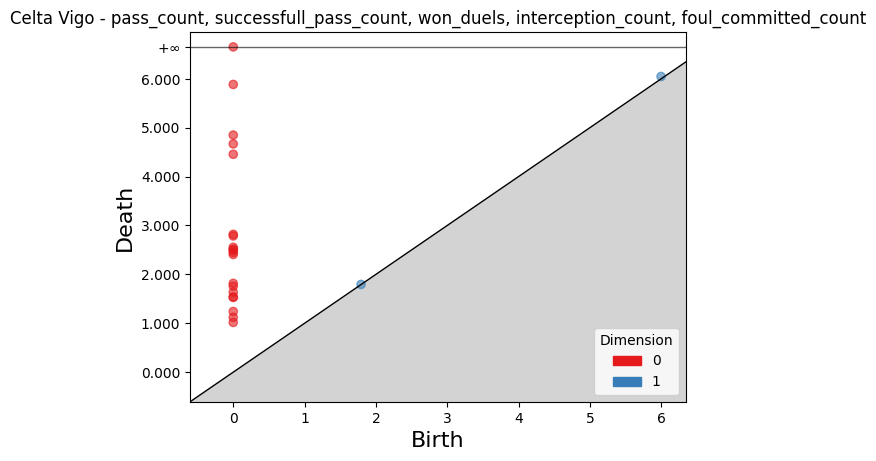

Eibar


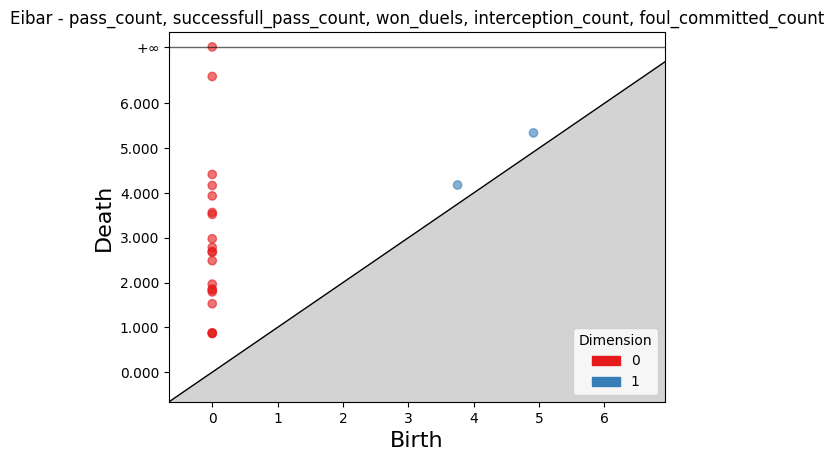

Espanyol


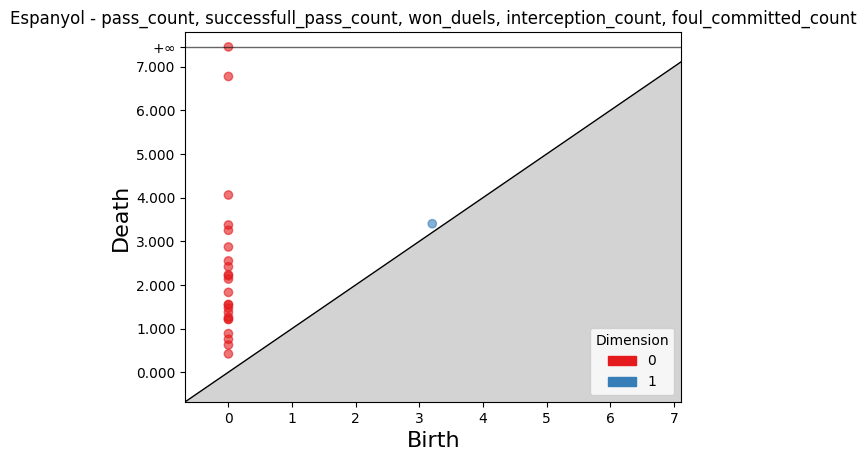

Getafe


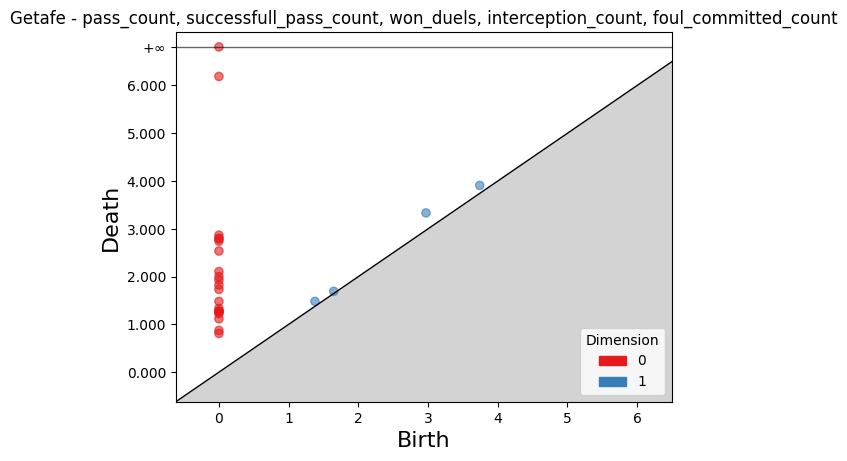

Granada


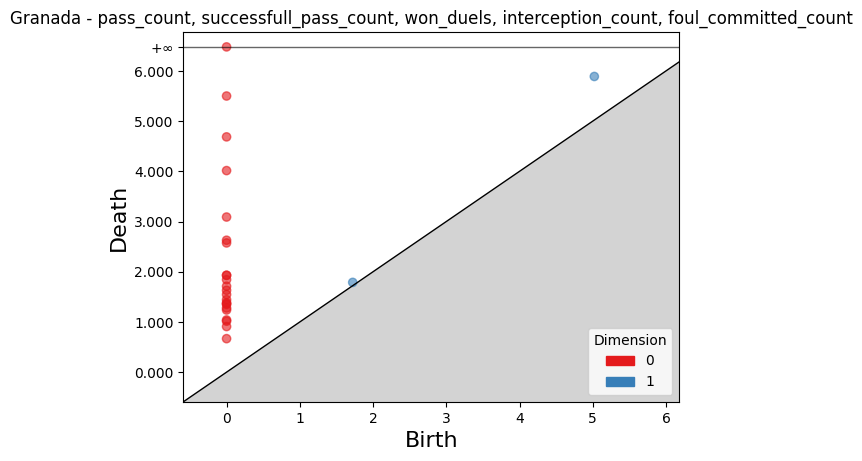

Las Palmas


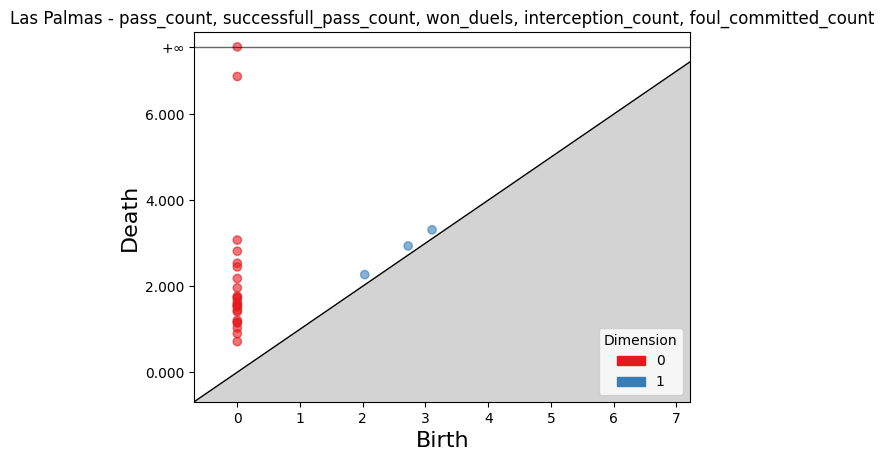

Levante UD


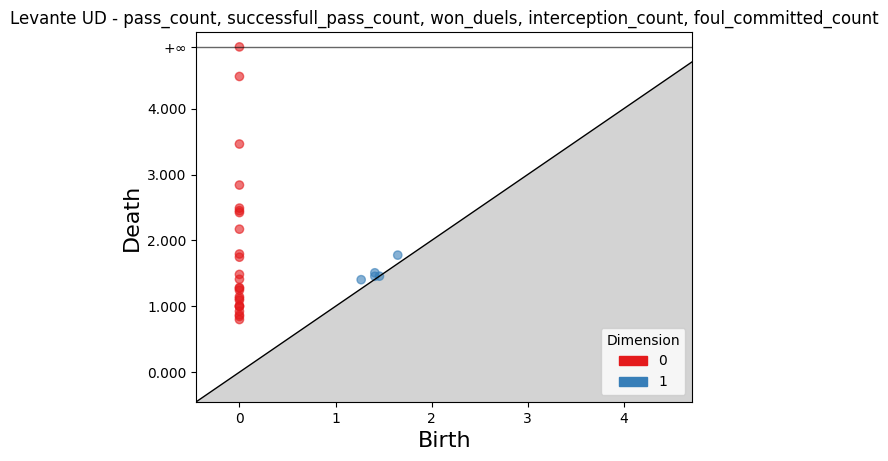

Málaga


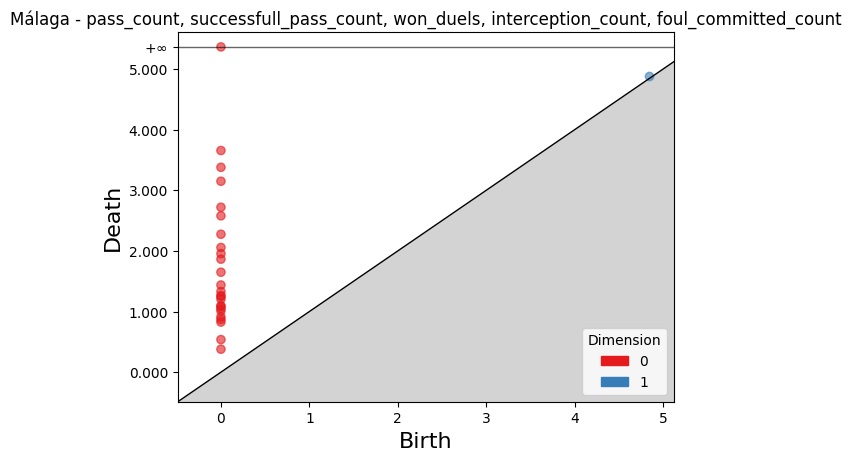

RC Deportivo La Coruña


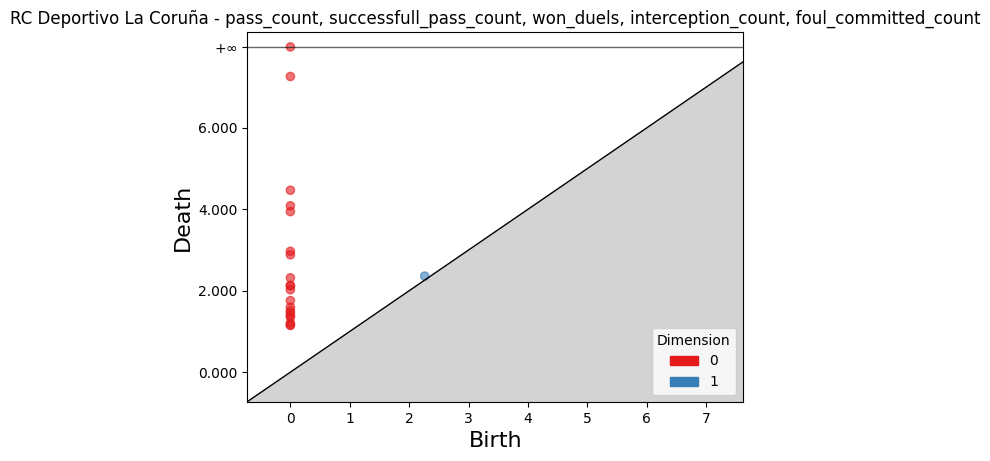

Rayo Vallecano


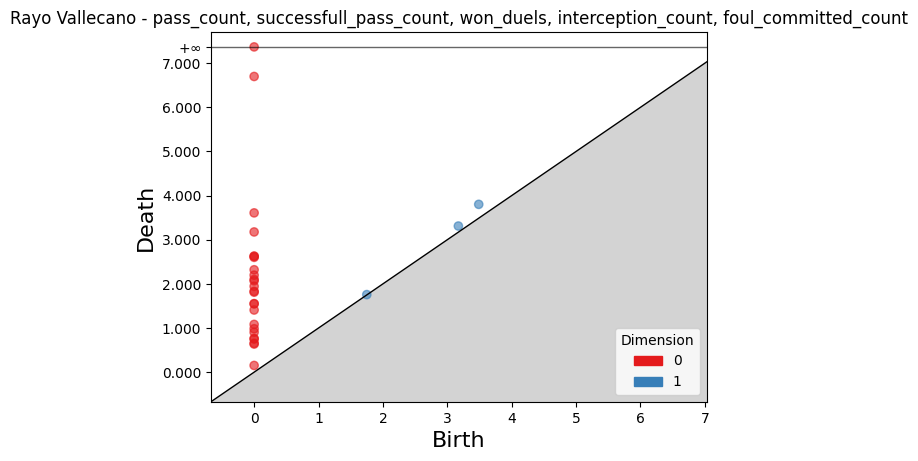

Real Betis


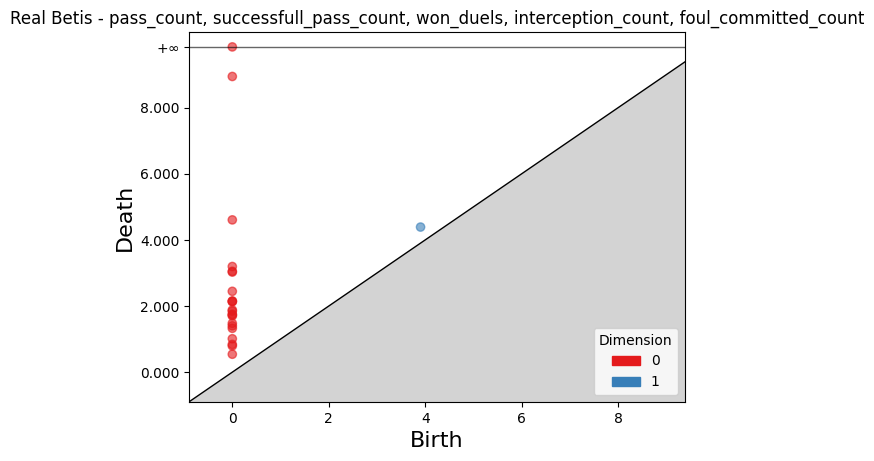

Real Madrid


KeyboardInterrupt: 

In [3]:
import gudhi as gd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsbombpy import sb
import re
import pandas as pd
import os
import warnings
import numpy as np
from itertools import combinations
import random

warnings.filterwarnings("ignore", category=UserWarning)

top5 = [(11, "La Liga", "La_Liga"), (9, "Bundesliga", "Bundesliga"), (2, "Premier League", "Premier_League"), (12, "Serie A", "Serie_A"), (7, "Ligue 1", "Ligue_1")]

countable_features = [
    'xG',                  
    'key_passes',          

    
    'pass_count',          
    'successfull_pass_count',  
    'xA',                  

    
    'won_duels',           
    'successful_tackles',  
    'interception_count',  

    
    'foul_committed_count',  
    'fouls_suffered_count',  
]


four_feature_combinations = [list(combo) for combo in combinations(countable_features, 5)]

random_combos = random.sample(four_feature_combinations, 25)


for combo in random_combos:
    features_str = ', '.join(combo)
    selected_features = countable_features

    output_dir_ = f'random/{features_str}'
    os.makedirs(output_dir_)

    selected_features_avg = []
    player_count = 0

    
    for (comp_id, comp_name, comp_safe_name) in top5:
        matches = sb.matches(competition_id=comp_id, season_id=27)
        teams = list(set(matches['home_team'].tolist()))
        for team in teams:
            safe_team = re.sub(r'[^\w\s]', '', team).replace(" ", "_")
            output_dir = f"{comp_safe_name}_2015-2016/{safe_team}"
            df = pd.read_csv(f"{output_dir}/{safe_team}_season_stats.csv")  
            data_ = df[selected_features].sum()
            player_count += df.shape[0]
            selected_features_avg.append(data_)
    
    if selected_features_avg:
        selected_features_avg_df = pd.DataFrame(selected_features_avg)
        avg_values = selected_features_avg_df.sum() / player_count
        print(avg_values)
    else:
        print("Nincs elegendő adat az átlag számításához.")
    
    for (comp_id, comp_name, comp_safe_name) in top5:
        
        matches = sb.matches(competition_id=comp_id, season_id=27)
        teams = sorted(list(set(matches['home_team'].tolist())))
        
        H0_avg = []
        for team in teams:
            print(team)
            team_matches = matches[(matches['home_team'] == team) | (matches['away_team'] == team)]
            team_home_wins = team_matches[(team_matches['home_team'] == team) & (team_matches['home_score'] > team_matches['away_score'])]
            team_away_wins = team_matches[(team_matches['away_team'] == team) & (team_matches['away_score'] > team_matches['home_score'])]
            team_draws = team_matches[team_matches['home_score'] == team_matches['away_score']]

             
            team_points = (team_home_wins.shape[0] + team_away_wins.shape[0])*3 + team_draws.shape[0]
            
            
            safe_team = re.sub(r'[^\w\s]', '', team).replace(" ", "_")
            output_dir = f"{comp_safe_name}_2015-2016/{safe_team}"
            
            df = pd.read_csv(f"{output_dir}/{safe_team}_season_stats.csv")  
        
            df = df[df['minutes_played'] >= 300] 
            
            data_scaled_avg = df[selected_features].to_numpy() / avg_values.to_numpy() 
            
        
            rips_complex = gd.RipsComplex(points=data_scaled_avg, max_edge_length=1000.0)
            simplex_tree = rips_complex.create_simplex_tree(max_dimension=4)
            
            diag = simplex_tree.persistence()
            
            persistence_intervals = simplex_tree.persistence_intervals_in_dimension(0)
            
            H0_sum = 0
            i = 0
            for H0 in persistence_intervals:
                if H0[1] != np.inf:
                    H0_sum += H0[1]
                    i = i+1
            
            H0_avg.append((team, H0_sum / i if i != 0 else 0, team_points))
                
            
            gd.plot_persistence_diagram(diag)
            plt.title(f'{team} - {features_str}')
            plt.show()
            
            
        H0_avg.sort(key=lambda x: x[1], reverse=True)
        fig, ax = plt.subplots(figsize=(8, 5))

        
        for team in H0_avg:
            ax.scatter(team[1], team[2], label=team[0])
            
        ax.set_xlabel("H0 Avg")
        ax.set_ylabel("Points")
        ax.set_title(f'{comp_name} - {features_str}')
        plt.grid(True)
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.show()
